In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras import backend as K
from keras.models import Model
from keras.utils import plot_model

In [6]:
input_shape = (28, 28, 1)
n_classes = 10
kernel_size = 3
batch_size = 32
latent_dim = 16

# encoder/decoder number of filters per CNN layer
filters = [32, 64]
padding = 'same'
activation= 'relu'
strides = 2

In [10]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32').reshape((-1, 28, 28, 1))/ 255
x_test = x_test.astype('float32').reshape((-1, 28, 28, 1))/ 255

In [12]:
def get_encoder_output(encoder_inputs):
    x = encoder_inputs
    
    for filter in filters:
        x = Conv2D(filters = filter,
                   kernel_size=kernel_size,
                   padding=padding,
                   activation=activation,
                   strides=strides,
                   
                  )(x)
        
    conv_shape = K.int_shape(x)
    x = Flatten()(x)
    outputs = Dense(units=latent_dim)(x)
    return outputs , conv_shape

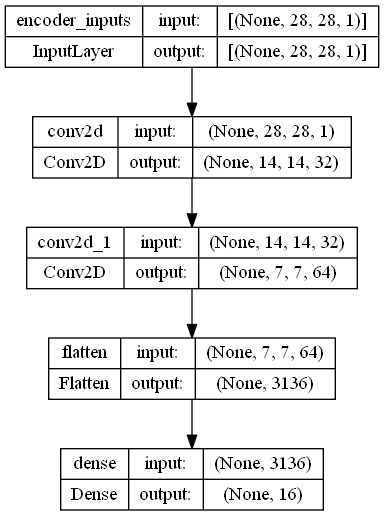

In [13]:
# create encoder
encoder_inputs = Input(shape=(28,28,1), name='encoder_inputs')
encoder_outputs, conv_shape = get_encoder_output(encoder_inputs)
encoder = Model(encoder_inputs, encoder_outputs, name='encoder')
plot_model(encoder, to_file='encoder.png', show_shapes=True)

In [15]:
def get_decoder_outputs(decoder_inputs, conv_shape):
    x = decoder_inputs
    x = Dense(units=conv_shape[1]*conv_shape[2]*conv_shape[3], activation=activation)(x)
    x = Reshape(conv_shape[1:])(x)
    
    for filter in filters[::-1]:  # reverse
        x = Conv2DTranspose(filters = filter,
                   kernel_size=kernel_size,
                   padding=padding,
                   activation=activation,
                   strides=strides)(x)
    outputs = Conv2DTranspose(filters = 1,
                   kernel_size=1,
                   padding=padding,
                   activation='sigmoid',
                   strides=1)(x)
    return outputs

In [17]:
# create decoder
decoder_inputs = Input(shape=(latent_dim,), name='decoder_inputs')
decoder_outputs = get_decoder_outputs(decoder_inputs, conv_shape)
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_inputs (InputLayer)  [(None, 16)]             0         
                                                                 
 dense_2 (Dense)             (None, 3136)              53312     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        33  

In [18]:
auto_encoder_inputs = encoder_inputs
auto_encoder_outputs = decoder(encoder(encoder_inputs))
auto_encoder = Model(auto_encoder_inputs, auto_encoder_outputs, name='auto-encoder')    
auto_encoder.summary()
# plot_model(auto_encoder, to_file='auto-encoder.png', show_shapes = True)

Model: "auto-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108737    
                                                                 
Total params: 177,745
Trainable params: 177,745
Non-trainable params: 0
_________________________________________________________________


In [19]:
auto_encoder.compile(loss='mse',
                     optimizer='adam')

In [20]:
auto_encoder.fit(x_train,
                 x_train,
                 batch_size=batch_size,
                 validation_data=(x_test, x_test),
                 epochs=5)

Epoch 1/5
 308/1875 [===>..........................] - ETA: 2:48 - loss: 0.0670

KeyboardInterrupt: 

In [21]:
x_decoded = auto_encoder.predict(x_test)
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, 28, 28))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

145/313 [============>.................] - ETA: 7s

KeyboardInterrupt: 